## Image Classification with LeNet 5

This notebook implements the classic [LeNet 5](https://en.wikipedia.org/wiki/LeNet\)  in PyTorch (we will use ReLU activations) and tests its performance on the MNIST dataset.

Workflow of the notebook:
1. Load dataset
2. Visualize
3. Create dataloaders
4. Neural Network definition
5. Train/Test Loop

In [1]:
# Imports
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# Set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# Download and load the training data
# Normalise and resize to 32x32 to match the LeNet5 input dimensions
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform = transform, download=True)

# Download and load the test data
test_dataset = datasets.MNIST(root='./data', train=False, transform = transform, download=True)

len(train_dataset),len(test_dataset)

(60000, 10000)

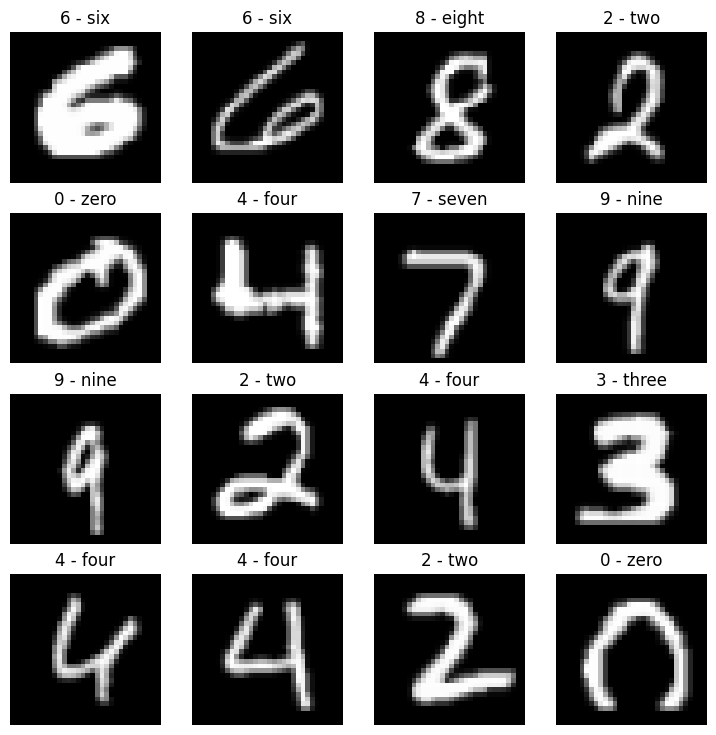

In [4]:
# Visualizing the data
def visualize(dataset, rows, cols):

  """Takes as input a dataset and plots a grid of rows by cols of images from the dataset """

  # Set random seed
  torch.manual_seed(42)
  # Get class names
  class_names = dataset.classes
  fig = plt.figure(figsize=(9, 9))
  for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(dataset), size=[1]).item()
    img, label = dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);



# Calling the visualize function
visualize(train_dataset, rows = 4, cols = 4)

In [5]:
# Next we have to make a dataloader

from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7c4490297880>, <torch.utils.data.dataloader.DataLoader object at 0x7c44902976d0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [6]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32]))

In [7]:
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super().__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        # This acts as a feature extractor
        self.features = nn.Sequential(
            # Conv block 1
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Conv block 2
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # This acts as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [8]:
# Model instant
model_0 = LeNet5(grayscale=True,
               num_classes=10)

model_0 = model_0.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [9]:
model_0

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [10]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
# Training Loop
epochs = 5
# Create training and testing loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss, train_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))


        # 4. Optimizer zero grad
        optimizer.zero_grad()

        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    # Divide total accuracy by length of test dataloader (per batch)
    train_acc /= len(train_dataloader)


    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}| Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")



Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.08699 | Train acc: 97.30| Test loss: 0.05352, Test acc: 98.32%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.05236 | Train acc: 98.40| Test loss: 0.04160, Test acc: 98.63%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.03763 | Train acc: 98.81| Test loss: 0.03568, Test acc: 98.82%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.03005 | Train acc: 99.08| Test loss: 0.04089, Test acc: 98.61%

Epoch: 4
-------
Looked at 0/600